Before running:  
1. `conda install -c conda-forge folium`  
2. `pip install geojsoncontour`
3. Download and unzip data files from "UW EV Temperature Map/data/processed_0.2.zip" or ".../processed_1.0.zip"

In [2]:
#import os
import numpy as np
import pandas as pd
import folium
import branca
from folium import plugins
from folium.plugins import TimestampedGeoJson
from folium import GeoJson
import matplotlib.pyplot as plt
#from scipy.interpolate import griddata
import geojsoncontour
#import scipy as sp
#import scipy.ndimage
import json

In [70]:
# Setup colormap
# Copied and modified from ref. 2

### change to 10 degree celcius interval 
### add search bar

colors = ['#0accba', '#9cff00', '#e8eb00', '#ff7300', '#ff0000']
levels = [0, 10, 50, 100, 200, 365]
cm = branca.colormap.LinearColormap(colors, index=levels, vmin=min(levels), vmax=max(levels))
cm = cm.to_step(index=levels)
cm.caption = 'Number of Days'

cm

Wall time: 3.11 s


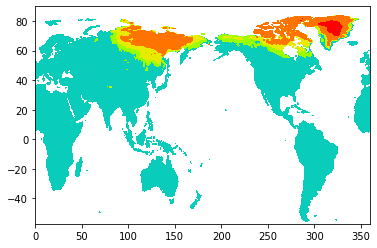

In [71]:
%%time
# read lon and lat coordinates. FILES ARE IN OUR GOOGLE DRIVE
# WILL CONSIDER USING SOME API TO ACCESS GOOGLE DRIVE FILES
# Copied and modified from ref. 1 and 2
lon = pd.read_csv('./processed_0.2_max/lon.csv', index_col=0)
lat = pd.read_csv('./processed_0.2_max/lat.csv', index_col=0).head(720)
x_mesh, y_mesh = np.meshgrid(lon, lat)

# read min/max temperature data
HDDs = pd.read_csv('./HDDs.csv', index_col=0).head(720)
blw_0 = pd.read_csv('./blw_0.csv', index_col=0).head(720)
blw_n20 = pd.read_csv('./blw_n20.csv', index_col=0).head(720)

# create the contour plot
contourf_hdd = plt.contourf(x_mesh, y_mesh, HDDs, colors=colors, linestyles='None', levels=levels)
contourf_blw_0 = plt.contourf(x_mesh, y_mesh, blw_0, colors=colors, linestyles='None', levels=levels)
contourf_blw_n20 = plt.contourf(x_mesh, y_mesh, blw_n20, colors=colors, linestyles='None', levels=levels)

# Convert matplotlib contourf to geojson
geojson_hdd = geojsoncontour.contourf_to_geojson(contourf=contourf_hdd, ndigits=5, stroke_width=2, fill_opacity=0.6)
geojson_hdd = json.loads(geojson_hdd)
geojson_blw_0 = geojsoncontour.contourf_to_geojson(contourf=contourf_blw_0, ndigits=5, stroke_width=2, fill_opacity=0.6)
geojson_blw_0 = json.loads(geojson_blw_0)
geojson_blw_n20 = geojsoncontour.contourf_to_geojson(contourf=contourf_blw_n20, ndigits=5, stroke_width=2, fill_opacity=0.6)
geojson_blw_n20 = json.loads(geojson_blw_n20)

In [72]:
band_data_hdd = []
band_data_blw_0 = []
for i in range(len(geojson_hdd['features'])):
    new_data = {'features': [geojson_hdd['features'][i]], 'type': geojson_hdd['type']}
    band_data_hdd.append(new_data)

for i in range(len(geojson_blw_0['features'])):
    new_data = {'features': [geojson_blw_0['features'][i]], 'type': geojson_blw_0['type']}
    band_data_blw_0.append(new_data)

In [74]:
%%time
# copied and modified from ref. 1
# Set up the folium plot
geomap = folium.Map(location=(25, 180), zoom_start=2, tiles="cartodbpositron", min_zoom=1,
                    max_bounds=True, max_lat=90, max_lon=380, min_lat=-70, min_lon=-20, overlay=False)

hdd_group = folium.FeatureGroup(name="Number of Days below 18°C", overlay=True, show=True)
blw_0_group = folium.FeatureGroup(name="Number of Days below 0°C", overlay=True, show=False)
# Plot the contour plot on folium
for i in range(len(band_data_hdd)):
    gj = GeoJson(
        band_data_hdd[i],
        style_function=lambda x: {
            'color': x['properties']['stroke'],
            'weight': x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity': x['properties']['stroke-opacity'],
            'fillOpacity': x['properties']['fill-opacity']
        })

    #gj.add_child(folium.Popup('Temperature is in ({}, {}) °C'.format(levels[i], levels[i+1])))
    gj.add_to(hdd_group)

for i in range(len(band_data_blw_0)):
    gj = GeoJson(
        band_data_blw_0[i],
        style_function=lambda x: {
            'color': x['properties']['stroke'],
            'weight': x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity': x['properties']['stroke-opacity'],
            'fillOpacity': x['properties']['fill-opacity']
        })

    #gj.add_child(folium.Popup('Temperature is in ({}, {}) °C'.format(levels[i], levels[i+1])))
    gj.add_to(blw_0_group)

#cm.add_to(min_group)
#min_group.add_to(geomap)
#min_groups = folium.FeatureGroup(name="Minimum Temperature Map", overlay=True, show=True)
#min_groups.add_child(min_group)
#min_groups.add_child(cm)
hdd_group.add_to(geomap)
blw_0_group.add_to(geomap)


#folium.plugins.Search(min_group, search_zoom=5).add_to(geomap)
#folium.plugins.MousePosition().add_to(geomap)
#folium.plugins.LocateControl().add_to(geomap)

ctrl = folium.LayerControl(position='bottomleft', hideSingleBase=True, collapsed=False, autoZIndex=False)
ctrl.add_to(geomap)

# Add the colormap to the folium map
geomap.add_child(cm)

Wall time: 7 ms


In [75]:
# completely copied from ref. 2
# Fullscreen mode
plugins.Fullscreen(position='topright', force_separate_button=True).add_to(geomap)
 
# Plot the data
geomap.save('./static_days.html')

references: 
1. https://github.com/samirak93/snow/blob/master/Complete_Notebook.ipynb
2. https://www.tjansson.dk/2018/10/contour-map-in-folium/ 

In [2]:
"""
NUM_OF_MONTHS = 12
STEP = 7
"""

'\nNUM_OF_MONTHS = 12\nSTEP = 7\n'

In [43]:
"""
def date_forward(month, day, step=1):
    """
    #a function to forward date. e.g forward 4 days: 0428 ==> 0502
    """
    assert step > 0, "step must be positive"
    
    NUM_OF_DAYS = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
    day += step;
    while (month <= NUM_OF_MONTHS and day > NUM_OF_DAYS[month]):
        day -= NUM_OF_DAYS[month]
        month += 1
    
    return month, day
"""

In [12]:
"""
# more data formatting for plotting multiple multipolygons in `TimestampedGeoJson` plots
fmtd_dict = {'features':[], 'type': 'FeatureCollection'}
for i in range(len(dict_act['features'])):
    for coordinates in dict_act['features'][i]['geometry']['coordinates']:
        feature = {'geometry':{'coordinates':[], 'type': 'Polygon'}, 'properties':{}, 'type': 'Feature'}
        feature['geometry']['coordinates'] = coordinates
        feature['properties'] = dict_act['features'][i]['properties']
        fmtd_dict['features'].append(feature)
"""

In [45]:
"""
# some data formatting for `TimestampedGeoJson` plots
# completely copied from ref. 1
dict_act = data[0]
for i in range(len(dict_act['features'])):

    dict_act['features'][i]['properties']['color']=dict_act['features'][i]['properties'].pop('fill')
    dict_act['features'][i]['properties']['weight']=dict_act['features'][i]['properties'].pop('stroke-width')
    dict_act['features'][i]['properties']['fillOpacity']=dict_act['features'][i]['properties'].pop('fill-opacity')
    properties=dict_act['features'][i]['properties']
    gettime=properties.pop('time')
    new_properties = {'style': properties, 'times':[gettime]*len(dict_act['features'][i]['geometry']['coordinates'])}
    dict_act['features'][i]['properties'] = new_properties
"""